# Lending Club Case Study


## Problem Statement

Lending Club is a consumer finance marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return.

It specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant's profile.

Like most other lending companies, *lending loans to ‘risky’* applicants is the largest source of financial loss *(called credit loss)*. The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed.

In other words, **borrowers** who **default** cause the largest amount of **loss to the lenders**. In this case, the customers labelled as *'charged-off' are the 'defaulters'*.

The core objective of the excercise is to **help the company minimise the credit loss**. There are two potential sources of **credit loss** are:
* Applicant **likely to repay the loan**, such an applicant will bring in profit to the company with interest rates.** Rejecting such applicants will result in loss of business**.
 * Applicant **not likely to repay** the loan, i.e. and will potentially default, then approving the loan may lead to a financial loss* for the company
 
## Objectives
The goal is to *identify these risky loan applicants*, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA using the given [dataset](./data/loan.csv), is the aim of this case study.

If one is able to *identify these risky loan applicants*, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

In other words, **the company wants to understand the driving factors (or driver variables)** behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment. 

## DataSet Analysis

The data given below contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

- The dataset reflects loans post approval, thus does not represent any information on the rejection criteria process
    - Overall objective will be to observe key leading indicaters (driver variables) in the dataset, which contribute to defaulters
    - Use the analysis as a the foundation of the hypothesis
- The overall loan process is represented by three steps
    - Potential borrower requests for loan amount (loan_amnt)
    - The approver approves/rejects an amount based on past history/risk (funded_amnt)
    - The final amount offered as loan by the investor (funded_amnt_inv)

### Analysis based on Domain Understanding

#### Leading Attribute
- *Loan Status* - Key Leading Attribute (*loan_status*). The column has three distinct values
    - Fully-Paid - The customer has successfuly paid the loan
    - Charged-Off - The customer is "Charged-Off" ir has "Defaulted"
    - Current - These customers, the loan is currently in progress and cannot contribute to conclusive evidence if the customer will default of pay in future
        - For the given case study, "Current" status rows will be ignored

#### Decision Matrix
* *Loan Accepted* - Three Scenarios
    * *Fully Paid* -  Applicant has fully paid the loan (the principal and the interest rate)
    * *Current* - Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.
    * *Charged-off* - Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has *defaulted* on the loan 
* *Loan Rejected* - The company had rejected the loan (because the candidate does not meet their requirements etc.). Since the loan was rejected, there is no transactional history of those applicants with the company and so this data is not available with the company (and thus in this dataset)

#### Important Columns
The given columns are leading attributes, or **predictors**. These attributes are available at the time of the loan application and strongly helps in **prediction** of loan pass or rejection. Key attributes *Some of these columns may get dropped due to empty data in the dataset*
* **Customer Demographics**
  * Annual Income (annual_inc) - Annual income of the customer. Generally higher the income, more chances of loan pass
  * Home Ownership (home_ownership) - Wether the customer owns a home or stays rented. Owning a home adds a collateral which increases the chances of loan pass.
  * Employment Length (emp_length) - Employment tenure of a customer (this is overall tenure). Higher the tenure, more financial stablity, thus higher chances of loan pass
  * Debt to Income (dti) - The percentage of the salary which goes towards paying loan. Lower DTI, higher the chances of a loan pass.
  * State (addr_state) - Location of the customer. Can be used to create a generic demographic analysis. There could be higher delinquency or defaulters demographicaly. 
* **Loan Attributes**
  * Loan Ammount (loan_amt) 
  * Grade (grade)
  * Term (term)
  * Loan Date (issue_date)
  * Purpose of Loan (purpose)
  * Verification Status (verification_status)
  * Interest Rate (int_rate)
  * Installment (installment)
  * Public Records (public_rec) - Derogatory Public Records. The value adds to the risk to the loan. Higher the value, lower the success rate.
  * Public Records Bankruptcy  (public_rec_bankruptcy) - Number of bankruptcy records publocally available for the customer. Higher the value, lower is the success rate.
  

#### Ignored Columns
* The following types of columns will be ignored in the analysis. This is a generic categorization of the columns which will be ignored in our approach and not the full list.
   * **Customer Behaviour Columns** - Columns which describes customer behaviour will not contribute to the analysis. The current analysis is at the time of loan application but the customer behaviour variables generate post the approval of loan applications. Thus these attributes wil not be considered towards the loan approval/rejection process.
   * Granular Data - Columns which describe next level of details which may not be required for the analysis. For example grade may be relevant for creating business outcomes and visualizations, sub grade is be very granular and will not be used in the analysis


### Data Set Analysis based on understanding of EDA 


#### Rows Analysis
- Summary Rows: No summary rows were there in the dataset
- Header & Footer Rows - No header or footer rows in the dataset
- Extra Rows - No column number, indicators etc. found in the dataset
- Rows where the **loan_status = CURRENT will be dropped** as CURRENT loans are in progress and will not contribute in the decision making of pass or fail of the loan. The rows are dropped before the column analysis as it also cleans up unecessary column related to CURRENT early and columns with NA values can be cleaned in one go
- Find duplicate rows in the dataset and drop if there are


### Columns Analysis of the Dataset

#### Drop Columns 
- There are multiple columns with **NA values** only. The **columns will be dropped**. 
    - *This is evaluated after dropping rows with `loan_status = Current`*
    - `(next_pymnt_d, mths_since_last_major_derog, annual_inc_joint, dti_joint, verification_status_joint, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, inq_last_12m, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, mths_since_recent_bc_dlq, mths_since_recent_inq, mths_since_recent_revol_delinq, num_accts_ever_120_pd, num_actv_bc_tl, num_actv_rev_tl, num_bc_sats, num_bc_tl, num_il_tl, num_op_rev_tl, num_rev_accts, num_rev_tl_bal_gt_0, num_sats, num_tl_120dpd_2m, num_tl_30dpd, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, tot_hi_cred_lim, total_bal_ex_mort, total_bc_limit, total_il_high_credit_limit)`
- There are multiple columns where the **values are only zero**, the **columns will be dropped**
- There are columns where the **values are constant**. They dont contribute to the analysis, **columns will be dropped**
- There are columns where the **value is constant but the other values are NA**. The column will be considered as constant. **columns will be dropped**
- There are columns where **more than 65% of data is empty** `(mths_since_last_delinq, mths_since_last_record)` - **columns will be dropped**
- **Drop columns `(id, member_id)`** as they are **index variables and have unique values** and dont contribute to the analysis
- **Drop columns `(emp_title, desc, title)`** as they are **discriptive and text (nouns) and dont contribute to analysis**
- **Drop redundant columns `(url)`**. On closer analysis url is a static path with the loan id appended as query. It's a redundant column to `(id)` column
- **Drop customer behaviour columns which represent data post the approval of loan** 
    - They contribute to the behaviour of the customer. Behaviour of the customer is recorded post approval of loan and not available at the time of loan approval. Thus these variables will not be considered in analysis and thus dropped
    - `(delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, application_type)`
    
#### Convert Column Format
- `(loan_amnt, funded_amnt, funded_amnt_inv)` columns are Object and will be converted to float
- `(int_rate, installment, dti)` columns are Object and will be converted to float
- **strip "month"** text from `term` column and convert to integer
- Percentage columns `(int_rate)` are object. **Strip "%"** characters and convert column to float
- `issue_d` column **converted to datetime format**

#### Standardise Values
- All currency columns are rounded off to 2 decimal places as currency are limited to cents/paise etc only.

#### Convert Column Values
- `loan_status` column converted to boolean **Charged Off = False and Fully Paid = True**. This converts the column into ordinal values
- `emp_length` converted to integer with following logic. Note < 1 year is converted to zero and 10+ converted to 10.
    - < 1 year: 0,  
    - 2 years: 2,  
    - 3 years: 3,  
    - 7 years: 7,  
    - 4 years: 4,
    - 5 years: 5,
    - 1 year: 1,
    - 6 years: 6,
    - 8 years: 8,
    - 9 years: 9,
    - 10+ years: 10

#### Added new columns
- verification_status_n added. Considering domain knowledge of lending = Verified > Source Verified > Not Verified. verification_status_n correspond to {Verified: 3, Source Verified: 2. Not Verified: 1} for better analysis
- issue_y is year extracted from issue_d
- issue_m is month extracted from issue_d

### Ignored Rows and Columns because of missing data
*  Columns with high percentage of missing values will be dropped **(65% above for this case study)**
*  Columns with less percentage of missing value will be imputed
*  Rows with high percentage of missing values will be removed **(65% above for this case study)**

### Imputing vs Dropping Columns
- Approach taken here in this analysis, if total number of rows (for all columns) which are blank is less than 5% of the dataset, we are dropping the rows. If the total rows are greater than 5% we will impute
- If the dataset of blanks is considerably small, dropping the rows will possible be more accurate approach withoug impacting the dataset and the outcomes
- If the dataset of blanks are considerably large, dropping the rows will skew the analysis and impute approach will be taken
- In the current dataset, combined row count of blanks for `emp_length` and `pub_rec_bankruptcies` is 1730, which is 4.48% of the total rows thus dropping the rows will be the more accurate approach
- If imputing, we will correlate `emp_length` with `annual_inc`, with the logic that higher the length of employment, higher the salary potentially. With this approach, the outliers can potentially introduce noise.

### Outlier treatment and dropping of rows
- Approach taken in this analysis to drop all outlier rows
- The following columns were evaluated for outliers `loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti`
- Total rows dropped due to outlier treatment:  3791
- Percentage of rows dropped due to outlier treatment:  10.29 %


## Approach
- Step 0 - Data Cleaning & Manipulation Checklist
- Step 1 - Dropping Rows - where loan_status = "Current"
- Step 2 - Dropping Columns based on EDA and Domain Knowledge
- Step 3 - Convert the data types
- Step 4 - Imputing vs Dropping Columns
- Step 5 - Analysis of the dataset post cleanup
- Step 6 - Outlier Treatment
- Step 7 - **Analysis** - Univariate, Bivariate and Derived Metrics Analysis
- Step 8 - **Conclusions** Inferences and Recommendations

## Step 0 - Data Loading, Cleaning & Manipulation Checklist

### Imports and Initial Setup

In [723]:
# Importing core libraries required for the case study
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea
import datetime as dt
import warnings

# Setting max rows settings to 200 to display all the summary data
pd.set_option("display.max_rows", 200)

# Suppress warnings
warnings.filterwarnings('ignore')

### Load data from CSV

To make the program work, checkout the GitHub repo using the command:
```shell
git clone https://github.com/slahiri/LendingClubCaseStudy.git
```
Create a folder in the checked out location, here inside "LendingClubCaseStudy" folder and copy the loan.csv
```shell
mkdir data
cp /source_location/loan.csv /dest_location/LendingClubCaseStudy/data
```
Set the variable names ```data_folder``` and ```loan_csv``` corresponding to the folder name created and name of loan file below:


In [724]:
# Loading the loan raw dataset
data_folder = ".data"
loan_csv = "loan.csv"

# The "loan" variable represents the dataframe loaded from the CSV
loan = pd.read_csv('./' + data_folder + '/' + loan_csv, low_memory=False)

### Columns Review

In [725]:
# Print summary of Nulls, Blanks in the dataset
(loan.isnull().sum()/len(loan.index) * 100)

id                                  0.000000
member_id                           0.000000
loan_amnt                           0.000000
funded_amnt                         0.000000
funded_amnt_inv                     0.000000
term                                0.000000
int_rate                            0.000000
installment                         0.000000
grade                               0.000000
sub_grade                           0.000000
emp_title                           6.191303
emp_length                          2.706650
home_ownership                      0.000000
annual_inc                          0.000000
verification_status                 0.000000
issue_d                             0.000000
loan_status                         0.000000
pymnt_plan                          0.000000
url                                 0.000000
desc                               32.580507
purpose                             0.000000
title                               0.027696
zip_code  

## Step1 - Dropping Rows - where loan_status = "Current"

In [726]:
prev_rows = len(loan)

# The rows where loan_stats=Current are the data where the loan repayment is currently in progress
# The loans which are currently in progress will not contribute to decisions 
# of default or pass as it's difficult to predict the outcome
#
# Dropping the rwos early as, dropping all Currrent rows introduces NA columns which can be easily dropped
loan = loan[loan['loan_status'] != "Current"]

In [727]:
# Print current data statistics after dropping rows with loan_status "CURRENT"
curr_rows = len(loan)

print("Number of rows dropped where loan_status = 'Current':", (prev_rows - curr_rows))
print("Percentage of rows dropped = ", round((prev_rows - curr_rows)/prev_rows*100,2),"%")

Number of rows dropped where loan_status = 'Current': 1140
Percentage of rows dropped =  2.87 %


In [728]:
# Find any duplicate rows in the dataset
duplicate_rows = len(loan[loan.duplicated()])
if duplicate_rows <= 0:
    print("Duplicate Rows: ", duplicate_rows)
    print("No action needed")
else:
    print("Do something")

Duplicate Rows:  0
No action needed


## Step2 - Dropping Columns

In [729]:
# Dropping columns which is unique id in nature. They dont contribute to loan analysis

# Checking if member_id is unique
if len(loan['member_id'].unique()) == loan.shape[0]:
    print("member_id is unique, can be dropped")
    loan = loan.drop(['member_id'],  axis=1)
else:
    print("member_id is not unique, dont drop")

# Checking if id is unique
if len(loan['id'].unique()) == loan.shape[0]:
    print("id is unique, can be dropped")
    loan = loan.drop(['id'],  axis=1)
else:
    print("id is not unique, dont drop")

member_id is unique, can be dropped
id is unique, can be dropped


In [730]:
# Dropping text/description columns which wont contribute to overall analysis
# These are names of establishment etc which will not contribute to loan pass or failure
# THe URL column is a static link with id as the attribute. Its a redundant column
loan = loan.drop(['url', 'emp_title', 'desc', 'title'],  axis=1)

# Dropping column sub_grade as the current analysis will limit to Grade only
loan = loan.drop(['sub_grade'],  axis=1)

In [731]:
# Dropping all columns which refer to behavoural data of customer post loan approval 
# Behaviour data of the customers are captured post the loan approval
# The data is not available at the time of loan approval and thus cannot be used for calculations
loan = loan.drop(['delinq_2yrs', 'earliest_cr_line', 
                          'inq_last_6mths', 'open_acc', 'pub_rec', 
                          'revol_bal', 'revol_util', 'total_acc', 
                          'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                          'total_pymnt_inv', 'total_rec_prncp', 
                          'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                          'collection_recovery_fee', 'last_pymnt_d', 
                          'last_pymnt_amnt', 'last_credit_pull_d', 
                          'application_type'],  axis=1)

In [732]:
# Dropping all columns whose all the values are NA
# Print all NA columns for verification
print("Total columns with values NA: ", len(loan.columns[loan.isna().all()].tolist()),"\n\n")
print("Columns with all values as NA\n", loan.columns[loan.isna().all()].tolist())

# Dropping all the columns whose all the records are NaN or Null
loan = loan.dropna(axis='columns', how="all")

Total columns with values NA:  55 


Columns with all values as NA
 ['next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_7

In [733]:
# Dropping all columns with all zero values
loan = loan.loc[:, (loan != 0).any(axis=0)]

In [734]:
# Function to Drop all columns who have constant values (ignoring NA value)
# Example most of the columns is 1 and rest is NA, the column will be dropped
# If we have 1,2 and NA, the column wont be dropped
print("Columns with constant values with or without NA")
def drop_constant_columns(df):
    for c in df.columns:
        if df[c].nunique(dropna=True) == 1:
            print(c)
            df = df.drop(c, axis=1)
    return df

# Drop all constant columns from df1 (definition of constant is constant value across the rows, this ignores Na values)
loan = drop_constant_columns(loan)

Columns with constant values with or without NA
pymnt_plan
initial_list_status
collections_12_mths_ex_med
policy_code
chargeoff_within_12_mths
tax_liens


In [735]:
# Function which checks the amount of empty values in a dataframe and 
# drops the column if the amount of empty values is more than 65%
# 60% is the threshhold percentage which decides imputing vs dropping 
print("Columns with more that 65% empty records")
def drop_mostly_empty_columns(df):
    total_rows = len(df)
    for c in df.columns:
        # Drop columns whose mean na values exceed 65%
        if df[c].isna().mean().round(2) >= 0.65:
            print(c)
            df = df.drop(c, axis=1)
    return df
loan = drop_mostly_empty_columns(loan)

Columns with more that 65% empty records
mths_since_last_delinq
mths_since_last_record


## Step3 - Convert the data types

In [736]:
# Convert the columns loan_amnt and funded_amnt as flot64
loan = loan.astype({'loan_amnt':'float','funded_amnt':'float'})

In [737]:
# Convert the term column into an integer from a string
loan['term'] = loan['term'].apply(lambda x : int(x[:-7]))

In [738]:
# Convert int_rate to  float by removing the "%" character
loan['int_rate'] = loan['int_rate'].apply(lambda x : float(x[:-1]))

In [739]:
# Round off the values of key float fields to 2 decimal place
# all int_rate and dti already limited to 2 edcimal
print("Rounding columns to 2 decimal places")
for c in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti']:
    print(c)
    loan[c] = loan[c].apply(lambda x: round(x,2))

Rounding columns to 2 decimal places
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
dti


In [740]:
# Converting the loan_status to boolean column. "Fully-Paid is True and Charged Off is False"
# Added a function instead of lambda because, if this is accidentally re-run on a boolean column, the logic broke
# Now it will only convert to boolean if the column is a string and has the two specific values
def convert_loan_status_to_boolean(x):
    if x == "Fully Paid":
        return True
    elif x == "Charged Off":
        return False
    else:
        return x

loan['loan_status'] = loan['loan_status'].apply(lambda x: convert_loan_status_to_boolean(x))

In [741]:
# Converting the column issue_d from string object to DateTime
loan['issue_d'] = pd.to_datetime(loan['issue_d'], format='%b-%y')

# Adding additional column for Year and Month for analysis extrating Year and Month from issue_d
loan['issue_y'] = pd.DatetimeIndex(loan['issue_d']).year
loan['issue_m'] = pd.DatetimeIndex(loan['issue_d']).month

In [742]:
# Converting the verification_status as Ordinal value with the following logic
# Verified - The documents are verified first hand with specific documents like Bank Statements, Identity Documents etc.
# Source Verified - The customer has been verified by third party source
# Not Verified - The customer has not been verified
# Considering domain knowledge of lending = Verified > Source Verified > Not Verified
# Replacing the nominal values with ordinal values {Verified: 3, Source Verified: 2. Not Verified: 1}
# Higher number given to more trusted source

loan['verification_status_nominal'] = loan['verification_status'].replace({'Verified': 3,
                                                                                   'Source Verified': 2,
                                                                                   'Not Verified': 1})

print(loan['verification_status_nominal'].value_counts())

1    16694
3    12206
2     9677
Name: verification_status_nominal, dtype: int64


## Step 4 - Imputing vs Dropping Columns

Evaluating the percentage of rows with blank values for both the columns. If the total percentage is less than 5% will take an option of dropping the columns vs imputing.

In [743]:
# Identify columns who have blank values and what percentage of total values are there blanks. 
# These values may need to be imputed
print('emp_length blank rows', loan['emp_length'].isna().sum())
print('pub_rec_bankruptcies blank rows', loan['pub_rec_bankruptcies'].isna().sum(), "\n")
imp_total = 0
for c in loan.columns[loan.isna().any()].tolist():
    imp_val = len(loan[loan[c].isna()]) / len(loan) * 100
    imp_total += imp_val
    print(c, round(imp_val, 2),"%")
print("\nTotal rows percentage whose columns are blank: ", round(imp_total ,2), "%")

emp_length blank rows 1033
pub_rec_bankruptcies blank rows 697 

emp_length 2.68 %
pub_rec_bankruptcies 1.81 %

Total rows percentage whose columns are blank:  4.48 %


In [744]:
# Converting emp_length to integer values
# Converting emp_length as numerical data to create more effective statistical analysis as compared to nominal values
loan['emp_length'] = loan['emp_length'].replace({'< 1 year': 0, '2 years': 2, '3 years': 3, 
                                                         '7 years': 7, '4 years': 4, '5 years': 5, 
                                                         '1 year': 1, '6 years': 6, '8 years': 8, 
                                                         '9 years': 9,  '10+ years': 10})



In [745]:
# Print the current dimensions of the dataframe
rows_before = len(loan)

In [746]:
# Drop rows with empty values in this scenario
# Since the percent of rows is very small, dropping the rows instead of imputing them
loan = loan[loan['emp_length'].notna()]
loan = loan[loan['pub_rec_bankruptcies'].notna()]

In [747]:
# Checking if blanks exist
loan['emp_length'].value_counts()

10.0    8369
0.0     4341
2.0     4207
3.0     3951
4.0     3297
5.0     3161
1.0     3077
6.0     2136
7.0     1689
8.0     1410
9.0     1209
Name: emp_length, dtype: int64

In [748]:
# Print the dimensions of the dataframe after dropping rows
rows_after = len(loan)
print("Number of rows dropped = ,", (rows_before - rows_after))
print("Percentage of rows dropped = ", round((rows_before - rows_after)/rows_before*100,2),"%")
print(loan.shape)

Number of rows dropped = , 1730
Percentage of rows dropped =  4.48 %
(36847, 21)


## Step 5 - Analysis of the dataset post cleanup

In [749]:
# Printing column info to analyse missing values, empty values in a column
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36847 entries, 0 to 39680
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   loan_amnt                    36847 non-null  float64       
 1   funded_amnt                  36847 non-null  float64       
 2   funded_amnt_inv              36847 non-null  float64       
 3   term                         36847 non-null  int64         
 4   int_rate                     36847 non-null  float64       
 5   installment                  36847 non-null  float64       
 6   grade                        36847 non-null  object        
 7   emp_length                   36847 non-null  float64       
 8   home_ownership               36847 non-null  object        
 9   annual_inc                   36847 non-null  float64       
 10  verification_status          36847 non-null  object        
 11  issue_d                      36847 non-nu

In [750]:
loan.shape

(36847, 21)

In [751]:
loan.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'verification_status_nominal'],
      dtype='object')

## Step 6 - Outlier Treatment

In [753]:
# This function creates a dictionary of outliers which includes the inter quartile range, 
# lower and upper bound for a particular column.
# Formulae used in this analysis
# IQR = 75th Quartile - 25th Quartile
# Lower Bound = 25th Quartile - 1.5 * IQR
# Upper Bound = 75th Quartile + 1.5 * IQR

def get_iqr(df, column):
    quar25 = df[column].quantile(0.25)
    quar75 = df[column].quantile(0.75)
    iqr = quar75 - quar25
    lower = quar25 - 1.5 * iqr
    upper = quar75 + 1.5 * iqr
    return {'quartile1': quar25, 'quartile3': quar75, 'iqr': iqr, 'lower_bound': lower, 'upper_bound': upper}


# The function treat outliers, prints a box plot for each column under consideration
# Plot 1 = Before outlier treatment
# Plot 2 = Post outlier treatment
# Also prints statistics of how many rows and percentage of rows dropped

def treat_outliers(df, column):
    p = sea.boxplot(df[column])
    p.set_title('Plot ['+ column + ']')
    plot.show()
    old_rows = len(df)
    
    print("Column Stats:\n", df[column].describe(), "\n")
    print("IQR Stats:\n", get_iqr(df, column), "\n")
    
    new_df = df[df[column] < get_iqr(df, column)['upper_bound']]
    
    p = sea.boxplot(new_df[column])
    p.set_title('Plot [' + column + '] - Post Outlier Treatment')
    plot.show()
    
    new_rows = len(new_df)
    print('Rows dropped: ', old_rows - new_rows)
    print('Percentage rows dropped: ', round((old_rows - new_rows)/old_rows*100,2), "%")
    
    return new_df

In [755]:
rows_before = loan.shape[0]

36847


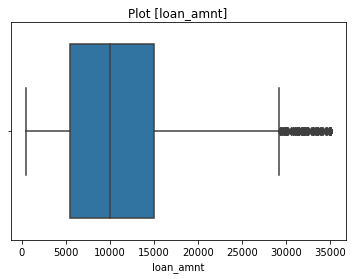

Column Stats:
 count    36847.000000
mean     11141.327652
std       7369.988994
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64 

IQR Stats:
 {'quartile1': 5500.0, 'quartile3': 15000.0, 'iqr': 9500.0, 'lower_bound': -8750.0, 'upper_bound': 29250.0} 



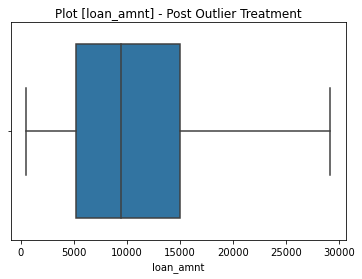

Rows dropped:  1078
Percentage rows dropped:  2.93 %


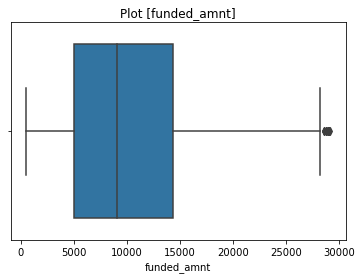

Column Stats:
 count    35769.000000
mean     10251.388073
std       6189.641067
min        500.000000
25%       5050.000000
50%       9125.000000
75%      14400.000000
max      29175.000000
Name: funded_amnt, dtype: float64 

IQR Stats:
 {'quartile1': 5050.0, 'quartile3': 14400.0, 'iqr': 9350.0, 'lower_bound': -8975.0, 'upper_bound': 28425.0} 



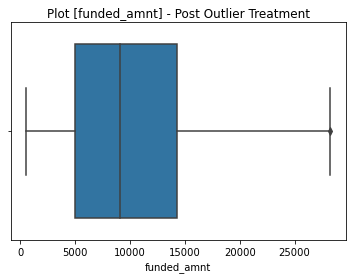

Rows dropped:  30
Percentage rows dropped:  0.08 %


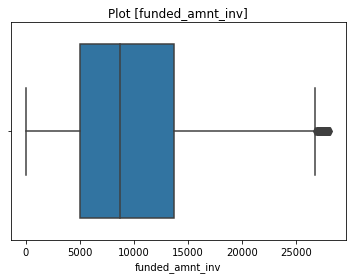

Column Stats:
 count    35739.000000
mean      9811.472166
std       6083.564117
min          0.000000
25%       5000.000000
50%       8672.460000
75%      13725.000000
max      28200.000000
Name: funded_amnt_inv, dtype: float64 

IQR Stats:
 {'quartile1': 5000.0, 'quartile3': 13725.0, 'iqr': 8725.0, 'lower_bound': -8087.5, 'upper_bound': 26812.5} 



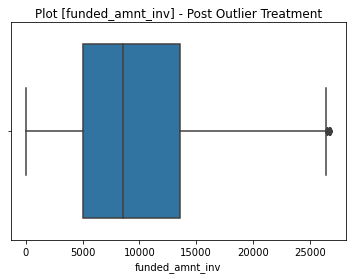

Rows dropped:  153
Percentage rows dropped:  0.43 %


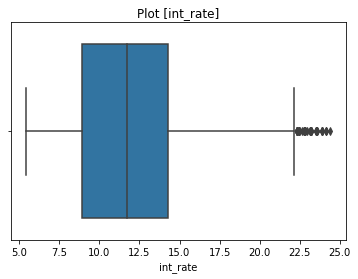

Column Stats:
 count    35586.000000
mean        11.863336
std          3.621997
min          5.420000
25%          8.940000
50%         11.710000
75%         14.270000
max         24.400000
Name: int_rate, dtype: float64 

IQR Stats:
 {'quartile1': 8.94, 'quartile3': 14.27, 'iqr': 5.33, 'lower_bound': 0.9449999999999994, 'upper_bound': 22.265} 



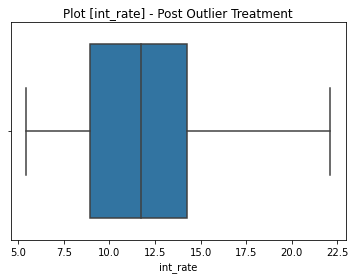

Rows dropped:  63
Percentage rows dropped:  0.18 %


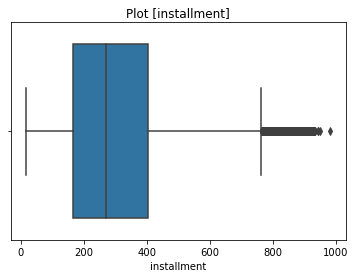

Column Stats:
 count    35523.000000
mean       305.802067
std        183.997022
min         16.080000
25%        164.820000
50%        271.450000
75%        404.435000
max        982.790000
Name: installment, dtype: float64 

IQR Stats:
 {'quartile1': 164.82, 'quartile3': 404.435, 'iqr': 239.615, 'lower_bound': -194.60250000000002, 'upper_bound': 763.8575000000001} 



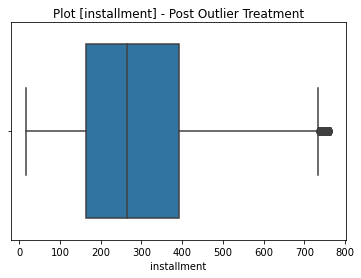

Rows dropped:  981
Percentage rows dropped:  2.76 %


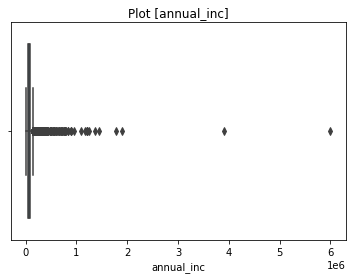

Column Stats:
 count    3.454200e+04
mean     6.609016e+04
std      6.181847e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.654700e+04
75%      8.000000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64 

IQR Stats:
 {'quartile1': 40000.0, 'quartile3': 80000.0, 'iqr': 40000.0, 'lower_bound': -20000.0, 'upper_bound': 140000.0} 



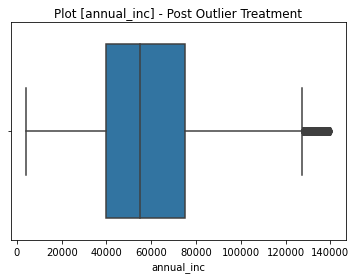

Rows dropped:  1486
Percentage rows dropped:  4.3 %


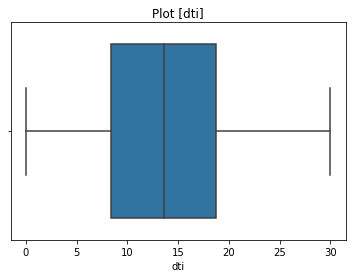

Column Stats:
 count    33056.00000
mean        13.47205
std          6.65394
min          0.00000
25%          8.38000
50%         13.58000
75%         18.74000
max         29.99000
Name: dti, dtype: float64 

IQR Stats:
 {'quartile1': 8.38, 'quartile3': 18.74, 'iqr': 10.359999999999998, 'lower_bound': -7.159999999999995, 'upper_bound': 34.279999999999994} 



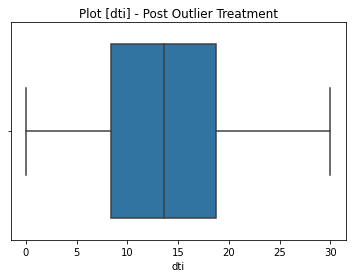

Rows dropped:  0
Percentage rows dropped:  0.0 %


In [756]:
# Execute outlier treatment to the columns 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 
# 'int_rate', 'installment', 'annual_inc', 'dti'

columns_outlier_treat = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti']

for c in columns_outlier_treat:
    loan = treat_outliers(loan, c)

In [757]:
rows_after = loan.shape[0]
print(rows_after)
print("Total rows dropped due to outlier treatment: ", (rows_before - rows_after))
print("Percentage of rows dropped due to outlier treatment: ", round((rows_before - rows_after)/rows_before*100,2),"%")

33056
Total rows dropped due to outlier treatment:  3791
Percentage of rows dropped due to outlier treatment:  10.29 %


In [719]:
# Taking a snapshot post outlier treatment
loan.to_csv('./.data/snapshot.clean.loan.csv') 

## Step 7 - Analysis

Analysis of key variables against loan status

In [811]:
def analysis_plots_v1(df, col):
    fig, p = plot.subplots(1,4,figsize=(18, 10))
    
    splot = sea.countplot(df[col], ax=p[0])
    p[0].set_title('['+ col + '] - loan_status=all')
    
    splot = sea.countplot(df[df['loan_status'] == True][col], ax=p[1])
    p[1].set_title('['+ col + '] - loan_status=True')
    
    splot = sea.countplot(df[df['loan_status'] == False][col], ax=p[2])
    p[2].set_title('['+ col + '] - loan_status=False')
    
    cross_tab = pd.crosstab(df[col], df['loan_status'], normalize='index')
    cross_tab.plot.bar(ax=p[3], stacked=True)
    
    p[3].set_title('['+ col + '] - Stacked')
    
    plot.show()

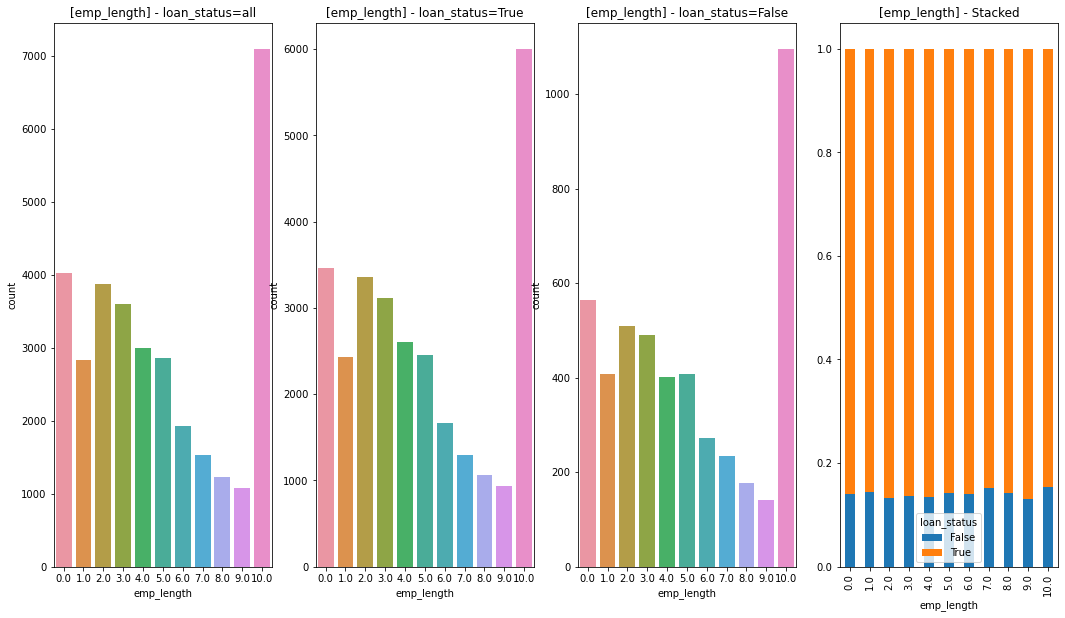

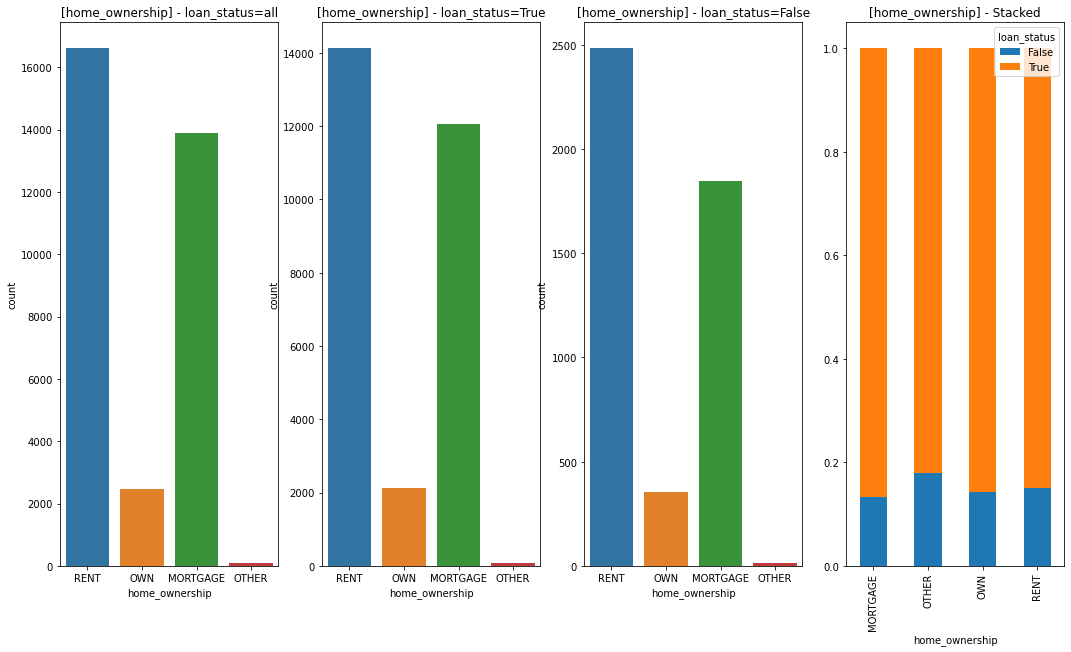

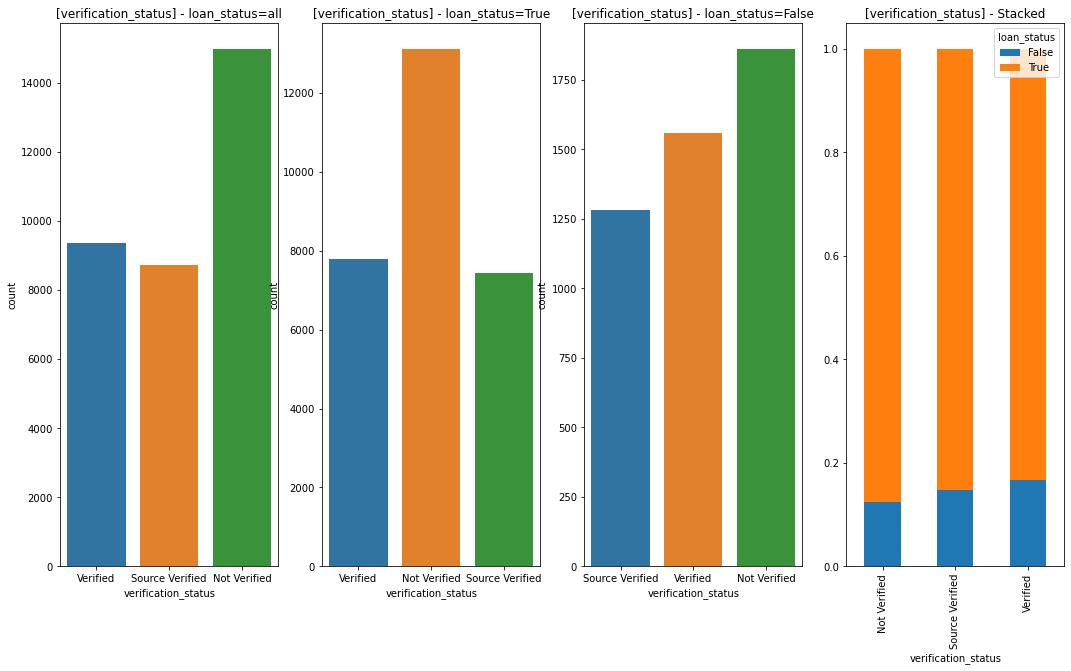

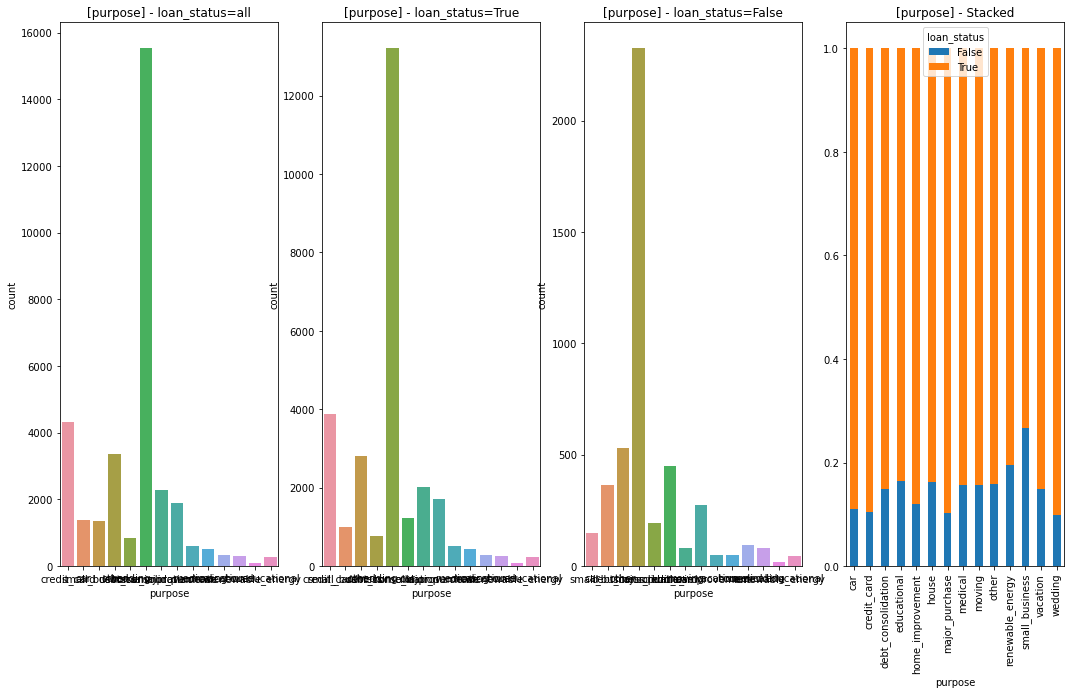

In [812]:
for c in ['emp_length', 'home_ownership', 'verification_status', 'purpose']:
    analysis_plots_v1(loan, c)